**Engy-4390** Nuclear Systems Design and Analysis, UMass Lowell, Chem. Eng. Nuclear Program Fall 2020

# NuScale 720 SMR BoP Simulation Final Report
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\uvar}{\boldsymbol{u}}
  \newcommand{\fvar}{\boldsymbol{f}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Power}{\mathcal{P}}
$

**Students:** Jack and Nik <br>
**Course:** Engy-4390 Nuclear Systems Design and Analysis  <br>
**Mentor:** Prof. Valmor F. de Almeida

UMass Lowell, Dept. of Chemical Engineering, Nuclear Energy Program 
<br>
**11Dec2020**

---
## Table of Contents<a id="toc"></a>
* [Introduction](#intro)
* [Objectives](#obj)
* [Approach](#app)
* [Input Data](#data)
* [Steady state](#ss)

* [Function library](#flib)
 + [Reactor](#reactor)
   - [One-Group Energy Neutron Balance](#nbal)

 + [Steam Generator](#steamgen)
 + [Turbine](#turbine)
 + [Condenser](#condenser)
 + [Coupling](#coupling)
    - [Vector ODE System](#vodes)
* [Startup: Reactivity Step with Negative Feedback Results](#res1)
* [References](#refs)
---

## [Introduction](#toc)<a id="intro"></a>

- As nuclear power continues to find its niche in the energy market, we are seeing an increasing trend towards Small Modular Reactors (SMRs). The benefit to SMRs is their small plant area, modularized reactor design allowing for more cost effective manufacturing, and their low level of operator interaction. 

- The NuScale 720 integral PWR has been under design for close to two decades. The 720 offers a safe design which uses no active components. Instead, the design relies primarily on gravity and natural convection which decreases the maintenance requirements of the system. NuScale Power Modules™ will be manufactured in factories, allowing for a monumental increase in production - the likes of which has never been seen by any other nuclear power plant design. With 2027 being the projected year for the first commercially operated plant, the NuScale 720 looks to become a mainstay in power generation for the U.S. 

- In the NuScale 720 design, the 12 modular reactors are submerged in a pool of water that acts as a heat sink. This pool is designed to respond to reactor conditions by drying up when external power is shut off. This leads to an air cooling mode that can be used in the case of long term (< 30 days) power shutdown. This is the only point where the different reactors influence each other, so it is imperative that each of our cores relates back to this water basin.

- The NuScale 720 has core inlet and outlet coolant temperatures of 265℃ and 321 ℃, respectively. The plant has 12 total reactor modules that split into two turbine buildings, each housing six turbines. Each core produces 200 MWt and 60 MWe for a total capacity to the grid, after considering plant consumption, of 685 MWe. The nominal coolant flow rate for one primary loop is 666 kg/s, whilst the nominal flow rate for the secondary loop is 87 kg/s.

- A balance of plant (BoP) is used to illustrate all components that are involved in energy production. A BoP includes systems like the core, steam generator, turbine, pressurizer, feed water system, and condenser. A BoP can be used to see how each part of the plant plays a role in the overall production of energy. The real time changes of key factors in each part of the reactor, such as changing the control rod level in the reactor, to see how it affects all the other parts of the plant over time. 

## [Objectives](#toc)<a id="obj"></a>

- A BoP will be created for the NuScale 720 reactor system using Python. We will use modules to mimic specific elements such as: the cores, condensers, steam generators, and turbines. A single point kinetics method will be used for modeling the core. A two temperature approach will be used to model the heat transfer meaning we only consider the inlet and outlet temperature of the module. We will be developing the model in Python with the use of the network modeling and HPC simulation library CORTIX. CORTIX will be used in conjunction with the Python modules to allow for dynamic modeling of the plant during start up and shut down of the reactors.

- Our goal for the project is to create a Balance of Plant dynamic system for the NuScale720 12 modular reactor plant. The following accident scenarios will be modeled: melting scenarios, primary loop breaking, and temperature rates during loss of cooling (LOCA) scenarios.

## [Approach](#toc)<a id="app"></a>

- Figure 3 shows how each of the components of our model will feed into each other. The first step to building our model is to outline the inputs, outputs, and equations that govern each individual module in our simulation. Starting at our reactor, information about the tank (such as the level and temperature) go into our reactor module along with instructions from the controller, and feedback from the pressurizer. The reactor then outputs information about the primary loop flow to the steam generator which converts that input information into a steam output. This output steam information is then fed into the turbine system which calculates High, Intermediate, and Low condensate pressures as well as sending excess steam to a condenser that has feedback from a cooling tower. These different condensates from the turbine and the condenser feed into each other until they get to a high pressure feedwater heater tank that outputs information back into the starting reactor.

- A module for the integral plant components including the core, turbine, pressurizer, steam generator, condenser, and feed water system will be modeled using Python. Most information will be obtained from Nuclear Systems Volume 1 and Professor de Almeida’s previous work on making BoP systems for nuclear reactors. 

|     **Module**        |      **Inputs**      |      **Outputs**       |     **Legend**     |
|:----------------------|:---------------------|:-----------------------|:-------------------|
| Core (CR)             |-F,T,P from SG        |-F,T,P, to SG           |-F: Flowrate        |
|                       |-F,T,P from PR        |-F,T,P, to PR           |-T: Temperature     |
|                       |-H from OWP           |-Q to OWP               |-P: Pressure        |
|Pressurizer (PR)       |-F,T,P from CR        |-F,T,P to CR            |-Q: Heat rate       |
|                       |                      |                        |-X: Steam quality   |
|                       |                      |                        |-H: Height          |
|                       |                      |                        |-E: Electrical power|
|Steam Generator (SG)   |-F,T,P from CR and FWS|-F,T,P to CR            |                    |
|                       |                      |-F,T,P,X to TU          |                    |
|Turbine (TU)           |-F,T,P,X from TU      |-E output as electricity|                    |
|                       |                      |-F,T,P,X to CD and FWS  |                    |
|Condenser (CD)         |-F,T,P,X from TU      |-F,T,P to FWS           |                    |
|                       |-Q from cooling tower |                        |                    |
|Feed Water System (FWS)|-F,T,P from CD and TU |-F,T,P to CR            |                    |
|Open Water Pool (OWP)  |-Q from CR            |-H to all CRs           |                    |

- Because we are only a two man group. We will be sharing most of the work and the work will be recorded through weekly progress reports. A schedule of our planned work is shown in table 2.

In [1]:
try:
    import cortix, iapws
except ImportError:
    print('Installing missing packages...')
    print('')
    !pip install cortix iapws
    import cortix, iapws

from cortix import Cortix
from cortix import Network

from reactor import SMPWR
from steamer import Steamer
from condenser import Condenser
from turbine import Turbine

import unit

end_time = 1 * unit.hour 
time_step = 30.0 * unit.second
show_time = (True, 5*unit.minute)

plant = Cortix(use_mpi=False, splash=True) # System top level

plant_net = plant.network = Network() # Network

[24046] 2020-11-22 01:59:56,295 - cortix - INFO - Created Cortix object 
_____________________________________________________________________________
                             L A U N C H I N G                               
_____________________________________________________________________________
      ...                                        s       .     (TAAG Fraktur)
   xH88"`~ .x8X                                 :8      @88>
 :8888   .f"8888Hf        u.      .u    .      .88      %8P      uL   ..
:8888>  X8L  ^""`   ...ue888b   .d88B :@8c    :888ooo    .     .@88b  @88R
X8888  X888h        888R Y888r ="8888f8888r -*8888888  .@88u  ""Y888k/"*P
88888  !88888.      888R I888>   4888>"88"    8888    888E`    Y888L
88888   %88888      888R I888>   4888> "      8888      888E      8888
88888 `> `8888>     888R I888>   4888>        8888      888E      `888N
`8888L %  ?888   ! u8888cJ888   .d888L .+    .8888Lu=   888E   .u./"888&
 `8888  `-*""   /   "*888*P"    ^"8888*"     ^%

In [2]:
'''Reactor'''

reactor = SMPWR()  # Create reactor module

reactor.name = 'SMPWR'
reactor.save = True
reactor.time_step = time_step
reactor.end_time = end_time
reactor.show_time = show_time

plant_net.module(reactor)  # Add reactor module to network

The steam generator is modeled as a countercurrent heat exchanger using the number of of transfer units (NTU) where $\mathrm{NTU} \equiv \frac{\mathrm{UA}}{\mathrm{C}_{\mathrm{min}}}$. 

The heat transfer rate is given by $\mathrm{q}=\varepsilon \mathrm{C}_{\min }\left(\mathrm{T}_{\mathrm{h}, \mathrm{i}}-\mathrm{T}_{\mathrm{c}, \mathrm{i}}\right)$ where $C_{\mathrm{r}}=\frac{\mathrm{C}_{\mathrm{min}}}{\mathrm{C}_{\max }}$ and $C_{j}=\dot{\mathrm{m}}_{j} c_{p, j}$. 

The effectiveness, $\varepsilon$ , for a countercurrent heat exchanger is given by $\varepsilon=\frac{1-\exp \left[-\mathrm{NTU}\left(1-C_{r}\right)\right]}{1-C_{r} \exp \left[-\mathrm{NTU}\left(1-C_{r}\right)\right]}$ and is valid for $\left(C_{r}<1\right)$. 

Given the inlet temperatures the primary outlet temperature can be solved for from $\mathrm{T}_{\mathrm{h}, \mathrm{o}}=\mathrm{T}_{\mathrm{h}, \mathrm{i}^{-}} \frac{\mathrm{q}}{\mathrm{C}_{\mathrm{hot}}}$ and the seconday outlet temperature from $\mathrm{T}_{\mathrm{c}, \mathrm{o}}=\mathrm{T}_{\mathrm{c}, \mathrm{i}}+\frac{\mathrm{q}}{\mathrm{C}_{\text {cold }}}$

##### Calculated paramters/ constants: 

$\mathrm{C}_{\mathrm{hot}}=3729.7 \mathrm{~kW} / \mathrm{K}$

$\mathrm{C}_{\mathrm{cold}}=1110.5 \mathrm{~kW} / \mathrm{K}$

$c_{p, \text { primary }}=5.6000 \mathrm{~kJ} / \mathrm{kg}-\mathrm{K}$

$c_{p, \text { seconary }}=4.2980 \mathrm{~kJ} / \mathrm{kg}-\mathrm{K}$

Where all properties are assumed to be constant and $C_{\text {cold }}$ is a ficticious value in order to account for phase change. The actual secondary side outlet tempeprature is calculated from $\mathrm{T}_{\mathrm{c}, \mathrm{o}}=\mathrm{T}_{\mathrm{c}, \mathrm{i}}+\frac{\mathrm{q}}{\mathrm{C}_{\text {cold }}}$ , $\mathrm{q}_{\text {secondary }}=\mathrm{C}_{\text {cold }}\left(\mathrm{T}_{\mathrm{c}, \mathrm{o}}-\mathrm{T}_{\mathrm{c}, \mathrm{i}}\right)$, and separating the secondary side coolant into liquid heating, vaporizing, and gas heating sections.

$\Delta \mathrm{H}_{\mathrm{vap}}=1765.4 \mathrm{~kJ} / \mathrm{kg} @ 513 \mathrm{~K}$

$\mathrm{T}_{\mathrm{sat}}=516 \mathrm{~K}$

The gas heat capacity is given by $\int_{\mathrm{Tsat}}^{\mathrm{T}} \frac{\mathrm{c}_{\mathrm{p}}}{\mathrm{R}} \mathrm{dT}=\mathrm{A}\left(\mathrm{T}-\mathrm{T}_{\mathrm{sat}}\right)-\frac{\mathrm{B}}{2}\left(\mathrm{~T}^{2}-\mathrm{T}_{\mathrm{sat}}^{2}\right)$

where, for water, A = 3.470 and B = 1.450*$10^{3}$

In [3]:
'''Steamer'''

steamer = Steamer()  # Create steamer module

steamer.name = 'Steamer'
steamer.save = True
steamer.time_step = time_step
steamer.end_time = end_time
steamer.show_time = show_time

plant_net.module(steamer)  # Add steamer module to network

In [4]:
'''Turbine'''

turbine = Turbine()  # Create turbine module

turbine.name = 'Turbine'
turbine.save = True
turbine.time_step = time_step
turbine.end_time = end_time
turbine.show_time = show_time

#plant_net.module(turbine)  # Add turbine module to network

In [5]:
'''Condenser'''

condenser = Condenser()  # Create condenser module

condenser.name = 'Condenser'
condenser.save = True
condenser.time_step = time_step
condenser.end_time = end_time
condenser.show_time = show_time

#plant_net.module(condenser)  # Add condenser module to network

In [6]:
#'''Feedwater Heating system'''

#condenser = FWHS()  # Create condenser module

#condenser.name = 'Condenser'
#condenser.save = True
#condenser.time_step = time_step
#condenser.end_time = end_time
#condenser.show_time = show_time

#plant_net.module(condenser)  # Add condenser module to network

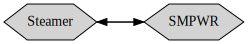

In [7]:
'''Balance of Plant Network Connectivity'''

plant_net.connect([reactor, 'coolant-outflow'], [steamer, 'primary-inflow'])
plant_net.connect([steamer, 'primary-outflow'], [reactor, 'coolant-inflow'])
#plant_net.connect([steamer, 'secondary-outflow'], [turbine, 'inflow'])
#plant_net.connect([turbine, 'outflow'], [condenser, 'condenser-inflow'])
#plant_net.connect([condenser, 'condenser-outflow'], [steamer, 'secondary-inflow'])

plant_net.draw()

In [8]:
'''Run'''

plant.run()  # Run network dynamics simulation

[24046] 2020-11-22 01:59:56,426 - cortix - INFO - Launching Module <reactor.SMPWR object at 0x7fa7884a1f10>
[24046] 2020-11-22 01:59:56,430 - cortix - INFO - Launching Module <steamer.Steamer object at 0x7fa767833ed0>
[24046] 2020-11-22 01:59:56,432 - cortix - INFO - SMPWR::run():time[m]=0.0
[24046] 2020-11-22 01:59:56,436 - cortix - INFO - Steamer::run():time[m]=0.0
[24046] 2020-11-22 01:59:56,602 - cortix - INFO - Steamer::run():time[m]=5.0
[24046] 2020-11-22 01:59:56,610 - cortix - INFO - SMPWR::run():time[m]=5.0
[24046] 2020-11-22 01:59:56,778 - cortix - INFO - Steamer::run():time[m]=10.0
[24046] 2020-11-22 01:59:56,785 - cortix - INFO - SMPWR::run():time[m]=10.0
[24046] 2020-11-22 01:59:56,941 - cortix - INFO - Steamer::run():time[m]=15.0
[24046] 2020-11-22 01:59:56,950 - cortix - INFO - SMPWR::run():time[m]=15.0
[24046] 2020-11-22 01:59:57,106 - cortix - INFO - Steamer::run():time[m]=20.0
[24046] 2020-11-22 01:59:57,113 - cortix - INFO - SMPWR::run():time[m]=20.0
[24046] 2020-11-

In [9]:
'''Close'''

plant.close()  # Properly shutdow plant

[24046] 2020-11-22 01:59:58,453 - cortix - INFO - Closed Cortix object.
_____________________________________________________________________________
                           T E R M I N A T I N G                             
_____________________________________________________________________________
      ...                                        s       .     (TAAG Fraktur)
   xH88"`~ .x8X                                 :8      @88>
 :8888   .f"8888Hf        u.      .u    .      .88      %8P      uL   ..
:8888>  X8L  ^""`   ...ue888b   .d88B :@8c    :888ooo    .     .@88b  @88R
X8888  X888h        888R Y888r ="8888f8888r -*8888888  .@88u  ""Y888k/"*P
88888  !88888.      888R I888>   4888>"88"    8888    888E`    Y888L
88888   %88888      888R I888>   4888> "      8888      888E      8888
88888 `> `8888>     888R I888>   4888>        8888      888E      `888N
`8888L %  ?888   ! u8888cJ888   .d888L .+    .8888Lu=   888E   .u./"888&
 `8888  `-*""   /   "*888*P"    ^"8888*"     ^%8

In [10]:
reactor = plant_net.modules[0]
steamer = plant_net.modules[1]

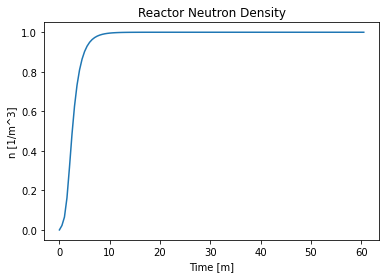

In [11]:
(quant, time_unit) = reactor.neutron_phase.get_quantity_history('neutron-dens')
quant.plot(x_scaling=1/unit.minute, y_scaling=1/max(quant.value), x_label='Time [m]', y_label=quant.formal_name+' ['+quant.unit+']')

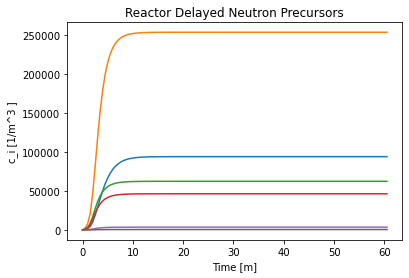

In [12]:
(quant, time_unit) = reactor.neutron_phase.get_quantity_history('delayed-neutrons-cc')
quant.plot(x_scaling=1/unit.minute, x_label='Time [m]', y_label=quant.formal_name+' ['+quant.unit+']')

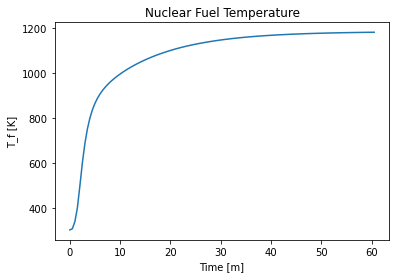

In [13]:
(quant, time_unit) = reactor.reactor_phase.get_quantity_history('fuel-temp')
quant.plot(x_scaling=1/unit.minute, x_label='Time [m]', y_label=quant.formal_name+' ['+quant.unit+']')

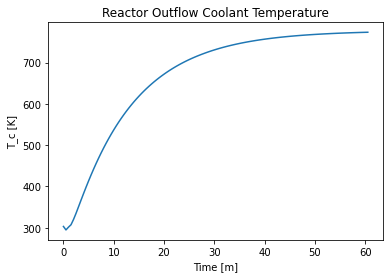

In [14]:
(quant, time_unit) = reactor.coolant_outflow_phase.get_quantity_history('temp')
quant.plot(x_scaling=1/unit.minute, x_label='Time [m]', y_label=quant.formal_name+' ['+quant.unit+']')

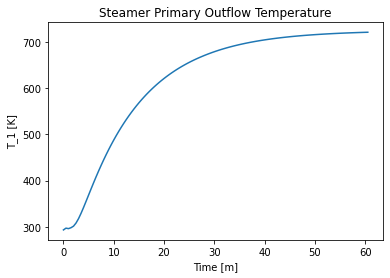

In [15]:
(quant, time_unit) = steamer.primary_outflow_phase.get_quantity_history('temp')
quant.plot(x_scaling=1/unit.minute, x_label='Time [m]', y_label=quant.formal_name+' ['+quant.unit+']')

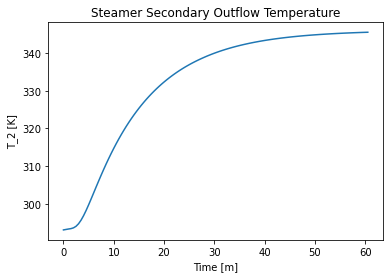

In [17]:
(quant, time_unit) = steamer.secondary_outflow_phase.get_quantity_history('temp')
quant.plot(x_scaling=1/unit.minute, x_label='Time [m]', y_label=quant.formal_name+' ['+quant.unit+']')

## [References](#toc)<a id="refs"></a>

- [1] J. Kennedy, N. Kemper, V. F. de Almeida, [Engy-4390: Small Modular Pressurized Water Reactor](https://github.com/dpploy/engy-4390/tree/main/projects/sm-pwr).
- [2] Dale Atkinson, “NuScale update for NASEO” Nuscale power, May 2019. Retrieved at:https://naseo.org/Data/Sites/1/atkinson_naseo-may-22,-2019.pdf 
- [3] V. F. de Almeida, [Cortix](https://cortix.org), *Network Dynamics Simulation*, University of Massachusetts Lowell, Dept. of Chemical Engineering (Nuclear program).
- [4] V. F. de Almeida, [*Engy-4350: Nuclear Reactor Engineering*](https://github.com/dpploy/engy-4350), University of Massachusetts Lowell, Dept. of Chemical Engineering (Nuclear Program).